# Pré-processamento do dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
X = [np.load(f'Inputs/Dados_{i}.npy') for i in range(1, 6)]
y = np.load('Inputs/Classes.npy', allow_pickle=True)

Np = 200
Hz = 10_000
t = np.arange(0, Np/Hz, 1/Hz)
freq = np.fft.fftfreq(len(t), t[1]-t[0])

print('Shape dos dados de cada sensor:\n','\n'.join([f'\tSensor {i+1}: {X[i].shape}' for i in range(5)]), '\n')
print('Shape dos dados de Classe:', y.shape, '\n')
print('Classes:', np.unique(y))

Shape dos dados de cada sensor:
 	Sensor 1: (50000, 201)
	Sensor 2: (50000, 201)
	Sensor 3: (50000, 201)
	Sensor 4: (50000, 200)
	Sensor 5: (50000, 200) 

Shape dos dados de Classe: (50000, 1) 

Classes: ['Classe A' 'Classe B' 'Classe C' 'Classe D' 'Classe E']


# Interpretação dos dados:
A partir das informoções de que há 5 dados de sensores, cada um com um formato (50000, ~200), e 1 dado de classe com formato (50000, 1), podemos deduzir que eles representam o seguinte esquema:

- 50.000 experimentos
- 200 pontos por experimento (0.02s)
- 5 canais
- Classe: Estado da máquina <u>por experimento</u>. O estado da máquina é constante durante cada experimento.


# Visualização de um experimento

Estado da máquina no experimento 11111: Classe B

Tabela:


,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5
0,-0.010469,0.455837,0.406143,50.0,25.136235
1,0.003428,0.253255,0.797168,50.0,29.017484
2,-0.043429,-0.031478,0.412057,50.0,21.768959
3,0.035873,-0.185538,0.186559,50.0,37.227771
4,-0.029478,-0.390151,-0.414762,50.0,29.357402
...,...,...,...,...,...
195,0.086258,-0.175936,-0.184464,50.0,124.009575
196,0.051223,-0.218309,0.123875,50.0,50.969140
197,-0.038778,-0.173600,0.300519,50.0,30.779624
198,-0.030047,-0.054342,0.337441,50.0,73.422415



Gráficos:


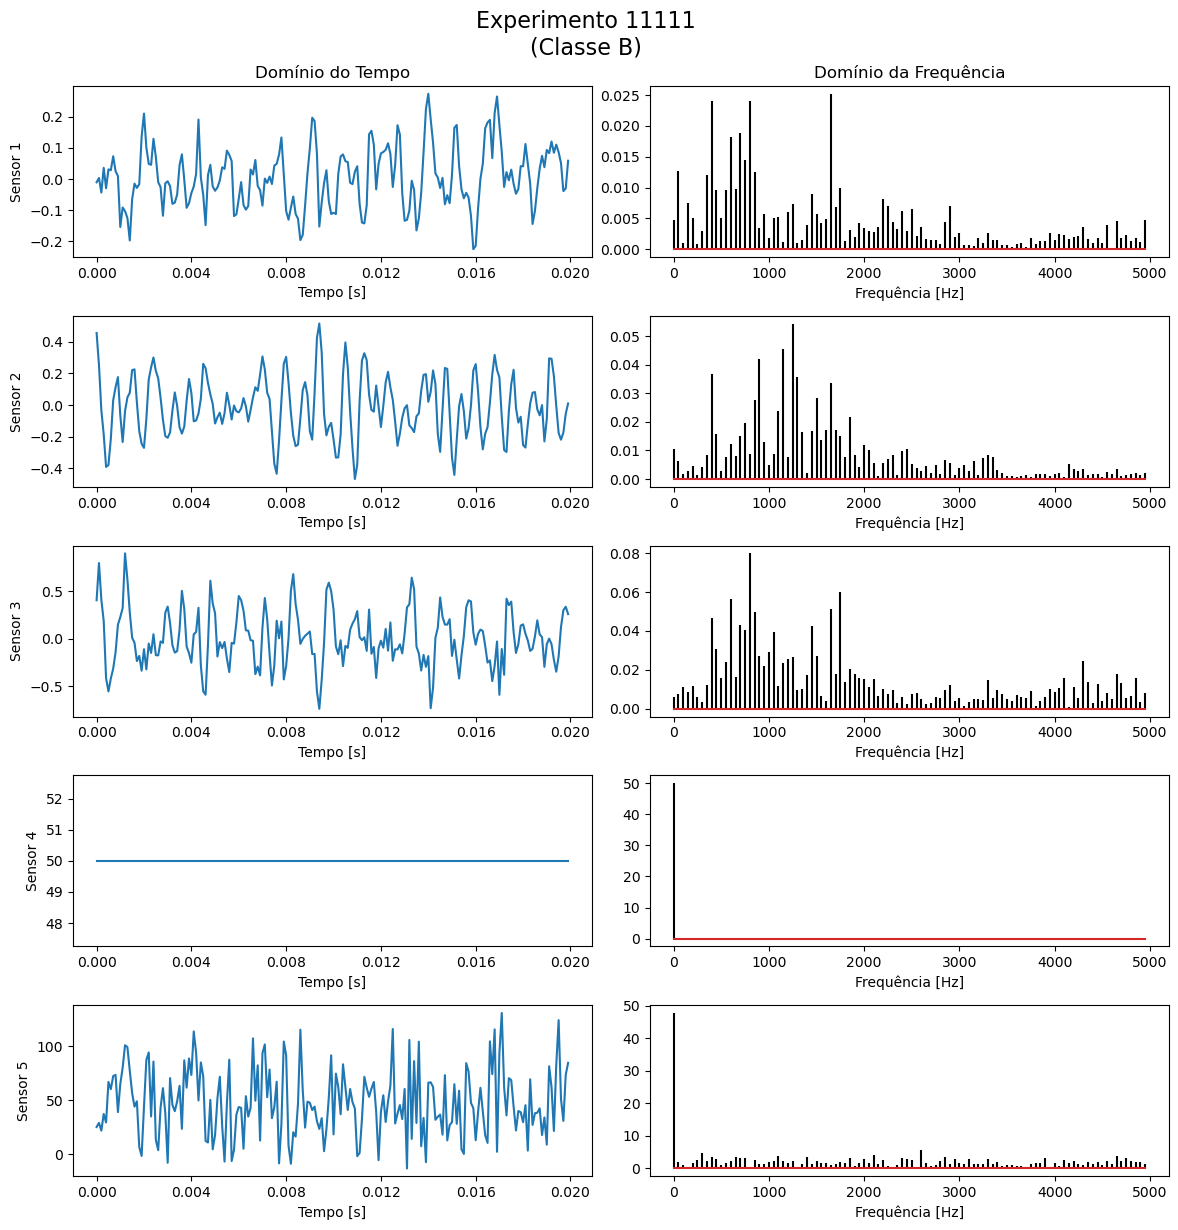

In [3]:
def tabela(n:int, cols = 5): #n: index do experimento (0-49999)
    out = {}#{'Tempo (s)': t}
    for idx, i in enumerate(X):
        out[f'Sensor {idx+1}'] = i[n][:Np]
        if idx+1 == cols:
            break
    df = pd.DataFrame(out)

    return df


def plot(n:int, cols=5): #n: index do experimento (0-49999)
    fig, ax = plt.subplots(cols, 2, figsize=(12, 2.5*cols))
    fig.suptitle(f'Experimento {n}\n({y[n][0]})', fontsize=16)
    ax[0][0].set_title('Domínio do Tempo')
    ax[0][1].set_title('Domínio da Frequência')

    for i in range(cols):
        x = X[i][n][:Np]
        fft = np.abs(np.fft.fft(x))/Np
        ax[i][0].plot(t, x)
        ax[i][1].stem(freq[:Np//2], fft[:Np//2], linefmt='k', markerfmt=" ")

        ax[i][0].set_xticks(np.linspace(0, 0.02, 6))
        ax[i][0].set_ylabel(f'Sensor {i+1}')
        ax[i][0].set_xlabel('Tempo [s]')
        ax[i][1].set_xlabel('Frequência [Hz]')        
    plt.tight_layout()
    plt.show()  



n = 11111
print(f'Estado da máquina no experimento {n}: {y[n][0]}')
print('\nTabela:')
display(tabela(n))
print('\nGráficos:')
plot(n)

# Seleção dos Sensores

Os sensores 1, 2 e 3 possuem as características esperadas para um comportamento de uma máquina elétrica.

Já os 4 e 5 possuem comportamentos inesperados, que não parecem contribuir positivamente para o treinamento de uma inteligência artifical, por esse motivo, os dados dos sensores 4 e 5 serão desconsiderados a partir daqui. 

# Remoção de Ruídos


Os sinais obtidos possuem diversos ruídos, que pode prejudicar o aprendizado de máquinas por adicionar dados que não são relevantes para encontrar os targets desejados.

Para filtrar esses ruídos e sinais indesejados duas medidas foram aplicadas:

### 1. Ignorar frequências altas

Todas as harmônicas com frequência maior que 2500Hz foram descartadas. Isso descartará vibrações de muito alta frequência, que não são interessantes nesse estudo.

### 2. Ignorar sinais de baixa amplitude

Todas as harmonicas restantes que possuem amplitude menor que 10% do pico são consideradas ruídos e descardadas.

## Exemplo:

A seguir será mostrado o mesmo dado de exemplo de antes da nossa filtragem e como ele ficou depois de passar por nosso filtro, tanto no domínio da frequência quanto na do tempo.

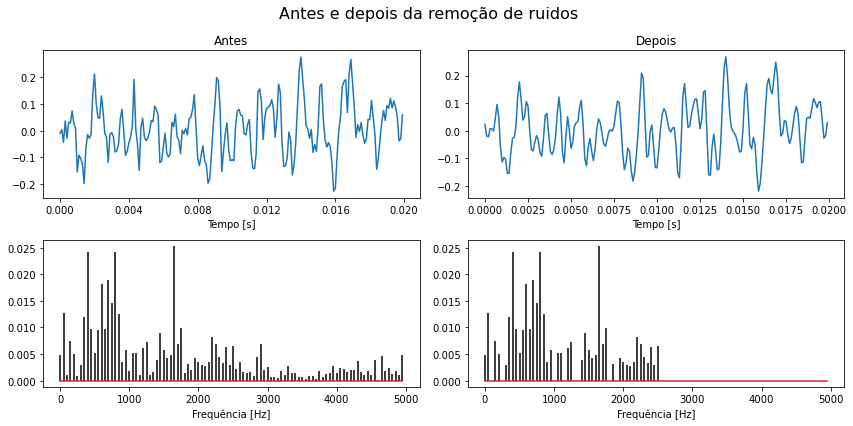

In [4]:
def remover_ruidos(A0, OmegMax = 2500, threshold = 0.1):
    A = A0.copy()
    for i in A:
        fft = np.fft.fft(A[i])/Np
        fft_mod = np.abs(fft)
        fft[abs(freq) > OmegMax] = 0
        pico = max(fft_mod)
        fft[fft_mod < threshold * pico] = 0
        A[i] = Np*np.fft.ifft(fft).real
    return A

# n=11111
# x = X[0][n][:Np]
# fig, ax = plt.subplots(2, 2, figsize=(12, 6))

# fft = np.abs(np.fft.fft(x))/Np
# ax[0][0].plot(t, x)
# ax[1][0].stem(freq[:Np//2], fft[:Np//2], linefmt='k', markerfmt=" ")

# x2 = remover_ruidos(tabela(n, cols=1))['Sensor 1']
# fft2 = np.abs(np.fft.fft(x2))/Np
# ax[0][1].plot(t, x2)
# ax[1][1].stem(freq[:Np//2], fft2[:Np//2], linefmt='k', markerfmt=" ")

# fig.suptitle('Antes e depois da remoção de ruidos', size=16)
# ax[0][0].set_xticks(np.linspace(0, 0.02, 6))
# ax[0][0].set_title(f'Antes')
# ax[0][1].set_title(f'Depois')
# ax[0][0].set_xlabel('Tempo [s]')
# ax[0][1].set_xlabel('Tempo [s]')
# ax[1][0].set_xlabel('Frequência [Hz]')        
# ax[1][1].set_xlabel('Frequência [Hz]')        
# plt.tight_layout()
# plt.show()  


# Extração das Features

Foram consideradas 16 features numéricas (11 no domínio do tempo e 5 no domínio da frequência) para cada um dos 3 sensores e 1 feature de categorização. O total de features é de $16*3 + 1 = 49$.

Sendo um elemento de uma coluna representado por $x_i$ e a coluna tendo $N$ elementos, as features são definidas como:

## Domínio do tempo:

### Média ($\mu_x$)

$$\mu_x = \frac{1}{N}\sum_{i=0}^{N} x_i$$

### Desvio Padrão ($\sigma_x$)

$$\sigma_x^2 = \frac{1}{N}\sum_{i=0}^{N} (x_i - \mu_x)^2$$

### Curtose ($\kappa_x$)

$$\kappa_x = \frac{1}{N}\sum_{i=0}^{N} \Bigg(\frac{x_i - \mu_x}{\sigma_x}\Bigg)^4$$

### Distorção ($\gamma_x$)

$$\gamma_x = \frac{1}{N}\sum_{i=0}^{N} \Bigg(\frac{x_i - \mu_x}{\sigma_x}\Bigg)^3$$

### Amplitude Pico a Pico ($x_{ppv}$)

$$x_{ppv} = max(x_i) - min(x_i)$$

### Valor Quadrático Médio ($x_{rms}$)

$$x_{rms} = \Bigg(\frac{1}{N}\sum_{i=0}^{N} x_i^2\Bigg)^{1/2} $$

### Raiz Quadrada da Amplitude ($x_{sra}$)

$$x_{sra} = \Bigg(\frac{1}{N}\sum_{i=0}^{N} \sqrt{\left |x_i  \right |}\Bigg)^2$$

### Fator de Crista ($x_{cf}$)

$$x_{cf} = \frac{max(\left | x_i \right |)}{x_{rms}}$$

### Fator de Impulso ($x_{if}$)

$$x_{if} = \frac{max(\left | x_i \right |)}{\frac{1}{N}\sum_{i=0}^{N} \left |x_i  \right |}$$

### Fator de Margem ($x_{mf}$)

$$x_{mf} = \frac{max(\left | x_i \right |)}{x_{sra}}$$

### Fator de Curtose ($x_{kf}$)

$$x_{kf} = \frac{\kappa_x}{x_{rms}^4}$$


## Domínio da Frequência:

### Média ($\mu_x$)

$$\mu_X = \frac{1}{N}\sum_{i=0}^{N} X_i$$

### Desvio Padrão ($\sigma_x$)

$$\sigma_X^2 = \frac{1}{N}\sum_{i=0}^{N} (X_i - \mu_X)^2$$

### Valor Quadrático Médio ($x_{rms}$)

$$x_{rms} = \Bigg(\frac{1}{N}\sum_{i=0}^{N} X_i^2\Bigg)^{1/2} $$

### Valor de Pico

$$max(X)$$

### Frequencia do Pico

$$f \space para \space quando \space max(X) \space é \space verdadeiro $$

## Categoria

A última coluna é a categoria daquele dataset, que é selecionado a partir da tabela 'Classes'

In [5]:
def feats(x, fft):
    N = len(x)
    mod = np.abs(x)
    u = x.mean() #x.mean()
    u_mod = mod.mean()
    std = x.std()
    amp =  x.max() - x.min()
    kurtosis = np.mean(((x - u) / std) ** 4)
    skew = np.mean(((x - u) / std) ** 3)
    rms = np.sqrt(np.mean(x**2))
    sra = np.mean(np.sqrt(np.abs(mod))) ** 2
    x_cf = max(mod) / rms
    x_if = max(mod) / u_mod
    x_mf = max(mod) / sra
    x_kf = kurtosis / (rms**4)

    freq = np.fft.fftfreq(len(x), 0.001)
    u_fft = fft.mean()
    std_fft = fft.std()
    rms_fft = np.mean(fft**2) ** (1/2)

    pico = fft.max()
    f_pico = abs(freq[fft.argmax()])
    
    return [u, std, kurtosis, skew, amp, rms, sra, x_cf, x_if, x_mf, x_kf, u_fft, std_fft, rms_fft, pico, f_pico]

def gerar_linha(A, n):
    linha = []
    for i in A:
        x = A[i][:Np]
        fft = np.abs( np.fft.fft(x) ) / Np
        f = feats(x, fft)
        linha += f
    linha += list(y[n])
    return linha
        


## Salvando checkpoint

In [6]:
# # Salvar o DataFrame        
# cabecalho = []        
# for i in ['1', '2', '3']:
#     cabecalho.append(f'med_{i}')
#     cabecalho.append(f'std_{i}')
#     cabecalho.append(f'kurt_{i}')
#     cabecalho.append(f'skew_{i}')
#     cabecalho.append(f'amp_{i}')
#     cabecalho.append(f'rms_{i}')
#     cabecalho.append(f'sra_{i}')
#     cabecalho.append(f'cf_{i}')
#     cabecalho.append(f'if_{i}')
#     cabecalho.append(f'mf_{i}')
#     cabecalho.append(f'kf_{i}')
#     cabecalho.append(f'medFFT_{i}')
#     cabecalho.append(f'stdFFT_{i}')
#     cabecalho.append(f'rmsFFT_{i}')
#     cabecalho.append(f'pico_{i}')
#     cabecalho.append(f'Fpico_{i}')
# cabecalho.append('Classe')

#valores = []
#for i in range(50000):
#    A = tabela(i, cols=3)    
#    valores.append(gerar_linha(A, i))
#    if i%500==0:
#        print(f'{1+i//500}%')

#df = pd.DataFrame(valores, columns = cabecalho) 
#df = df.sort_values(by=['Classe']).reset_index(drop=True)
#df.to_csv('Outputs/features_todas.csv', index=False)
#print('Salvo com sucesso!')

# Carregar o DataFrame
df = pd.read_csv('Outputs/features_todas.csv')
df

,med_1,std_1,kurt_1,skew_1,amp_1,rms_1,sra_1,cf_1,if_1,mf_1,...,cf_3,if_3,mf_3,kf_3,medFFT_3,stdFFT_3,rmsFFT_3,pico_3,Fpico_3,Classe
0,0.008246,0.089968,2.791291,-0.031547,0.450360,0.090121,0.057050,2.624840,3.376314,4.146370,...,2.767913,3.526430,4.230261,9.211182e+02,0.012995,0.010928,0.016979,0.049626,125.0,Classe A
1,0.013603,0.084510,2.958243,-0.335697,0.454219,0.085389,0.059767,2.884599,3.550124,4.121255,...,2.952264,3.661050,4.265138,1.247006e+03,0.010454,0.011253,0.015359,0.061991,45.0,Classe A
2,0.007995,0.107974,2.876807,0.040556,0.588548,0.108000,0.073456,2.990037,3.729967,4.396176,...,3.017817,3.796782,4.406506,2.758393e+02,0.014869,0.018142,0.023457,0.095776,165.0,Classe A
3,0.007647,0.079901,2.925226,0.181593,0.438584,0.080067,0.053716,2.779594,3.494876,4.143189,...,3.034847,3.818828,4.517698,8.481248e+02,0.011243,0.013108,0.017270,0.086695,170.0,Classe A
4,0.004620,0.001087,3.404259,0.326473,0.006241,0.004745,0.004555,1.744597,1.791983,1.817357,...,1.564872,1.598911,1.617400,1.177199e+09,0.000114,0.000479,0.000492,0.006813,0.0,Classe A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-0.001322,0.080573,2.402830,0.073113,0.391527,0.080382,0.056907,2.539793,3.091820,3.587470,...,2.527962,3.135235,3.700355,1.511734e+03,0.009109,0.011165,0.014410,0.072284,85.0,Classe E
49996,0.005143,0.089303,2.732346,-0.159354,0.459876,0.089228,0.059601,2.847687,3.567538,4.263200,...,2.673253,3.379696,4.030835,6.972908e+02,0.013395,0.011772,0.017832,0.053057,170.0,Classe E
49997,0.007034,0.082569,2.500881,0.165505,0.423173,0.082662,0.057084,2.969554,3.652664,4.300141,...,3.367601,4.181763,4.846669,2.132667e+03,0.009261,0.010273,0.013831,0.072374,40.0,Classe E
49998,0.004656,0.080629,2.574379,0.290409,0.389736,0.080562,0.054240,2.508750,3.132102,3.726164,...,2.976817,3.762913,4.419402,1.680889e+03,0.010445,0.010584,0.014871,0.057336,65.0,Classe E


# Remoção de Outliers

Para evitar outliears que podem distorcer os dados, eles são encontrados e removidos do banco de dados.

Um registro é considerado outlier se a distância desse registro até a média é pelo menos 2 vezes maior que a distância de 99% do dataset até a média.

Foram encontrados 1815 registros com essa característica, reduzindo-o de 1951 registros para 1812 (redução de 3.63%).


In [7]:
# Removendo registros que são outliers
df_orig = df.copy()
classes = df.Classe.unique()

def picos(x):
    a_max = np.abs(x.max() - x.mean())
    a99 = np.abs(np.percentile(x, 99) - x.mean())
    a01 = np.abs(np.percentile(x, 1) - x.mean())
    a_min = np.abs(x.min() - x.mean())
    teto = a_max / a99
    chao = a_min / a01
    return teto, chao


limiar_pico = 2
flag = 1
while flag:
    flag = 0  
    for i in df:
        if i != 'Classe':
            teto, chao = picos(df[i])

            while teto > limiar_pico or chao > limiar_pico:
                flag = 1 
                if teto > limiar_pico:
                    df = df.drop(df[i].idxmax())
                    teto, chao = picos(df[i])

      
                if chao > limiar_pico:
                    df = df.drop(df[i].idxmin())
                    teto, chao = picos(df[i])

n_antigo = len(df_orig)
n_novo = len(df)
                    
print('Registros iniciais:', n_antigo)
print('Registros finais:', n_novo)
print('Outliers Encontrados:', n_antigo - n_novo)
print(f'Redução de {(100 * (n_antigo - n_novo) / n_antigo):.2f}%')

Registros iniciais: 50000
Registros finais: 48185
Outliers Encontrados: 1815
Redução de 3.63%


# Seleção de Features

## Nível de relevância

Uma feature é considerada relevante se ela possuir dados com baixa variação dentro de cada classe e dados com muita variação entre as classes.

Foi ultilizada um threshold de 2.5, ou seja, para uma feature ser considerada útil a variação entre as classes deve ser no mínima 2.5 maior do que dentro de cada classse individualmente.


In [8]:
def vari(x):
    amp = x.max() - x.min()
    std = x.std()
    return (std / amp if amp !=0 else 0)

limiar_varmed = 2.5
filtro_1 = []
for i in df:
    if i != 'Classe':
        med = np.array([])
        var = np.array([])
        for j in classes:
            a = df[df['Classe'] == j][i]
            med = np.append(med, a.mean())
            var = np.append(var, vari(a))
 
        med2 = vari(med)
        var2 = var.mean()
        
    if med2 / var2 > limiar_varmed:
        filtro_1.append(i)

print("NÚMERO DE FEATURES ANTES", len(df.columns) - 1)        
print("NÚMERO DE FEATURES DEPOIS:", len(filtro_1))
print("\nFEATURES SELECIONADAS:")
print(filtro_1)




NÚMERO DE FEATURES ANTES 48
NÚMERO DE FEATURES DEPOIS: 41

FEATURES SELECIONADAS:
['med_1', 'std_1', 'kurt_1', 'skew_1', 'amp_1', 'rms_1', 'sra_1', 'cf_1', 'if_1', 'mf_1', 'kf_1', 'medFFT_1', 'stdFFT_1', 'rmsFFT_1', 'med_2', 'std_2', 'kurt_2', 'skew_2', 'amp_2', 'rms_2', 'sra_2', 'kf_2', 'medFFT_2', 'stdFFT_2', 'rmsFFT_2', 'pico_2', 'med_3', 'std_3', 'kurt_3', 'skew_3', 'amp_3', 'rms_3', 'sra_3', 'cf_3', 'if_3', 'mf_3', 'kf_3', 'medFFT_3', 'stdFFT_3', 'rmsFFT_3', 'pico_3']


## Matriz de Correlação

É notado que há várias features com um alto índice de correlação entre si, e isso deve ser evitado na hora de executar o aprendizado de máquina. O próximo bloco de código mostra como está a correlação entre as features até agora.

Em seguida será executado um algorítimo que irá identificar todas as correlações dentro do limite do threshold (positivo e negativo) e excluir uma das duas features da correlação. Restando apenas as features que possuem valores baixos de correlação entre si. O valor de threshold escolhido foi de 0.8.

Por fim são mostradas as features restantes 

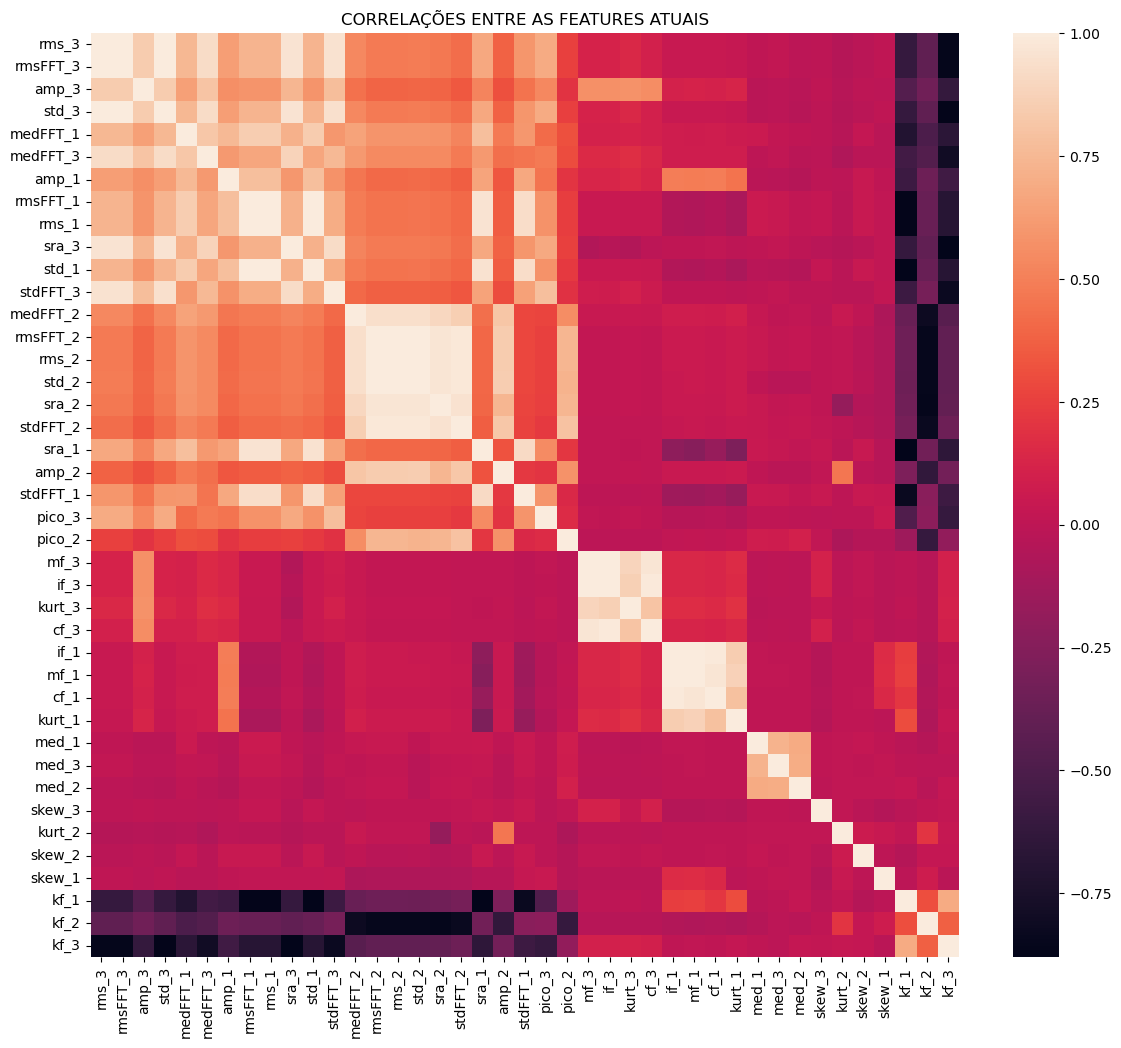

In [9]:
corr = df[filtro_1].corr()

order = [(i, sum(corr[i])) for i in corr]
order = sorted(order, key=lambda value: value[1], reverse=True)                  
order = [i[0] for i in order]        

corr = corr.reindex(order)[order]
plt.figure(figsize=(14, 12))
plt.title('CORRELAÇÕES ENTRE AS FEATURES ATUAIS')
sns.heatmap(corr)
plt.show()

NÚMERO DE FEATURES ANTES: 41
NÚMERO DE FEATURES DEPOIS: 17

FEATURES SELECIONADAS:
['amp_1', 'amp_2', 'pico_3', 'pico_2', 'cf_3', 'cf_1', 'kurt_1', 'med_1', 'med_3', 'med_2', 'skew_3', 'kurt_2', 'skew_2', 'skew_1', 'kf_1', 'kf_2', 'kf_3'] 



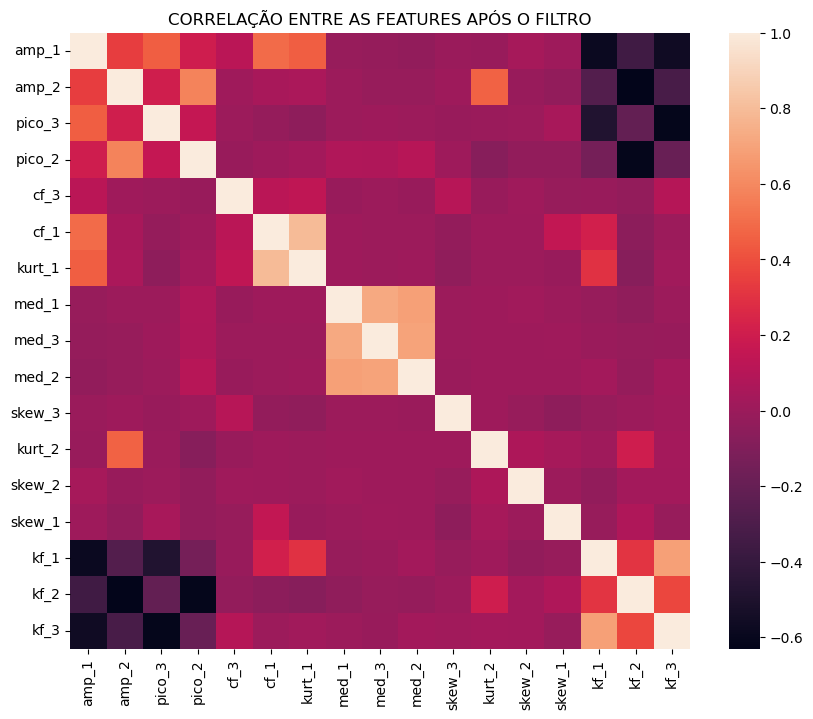

In [10]:
end = len(corr)
start = 1
threshold = 0.8

features = []
for i in corr:
    all_features = corr[i][start:end]
    if all(np.abs(all_features) < threshold):
        features.append(i)
    start += 1


print("NÚMERO DE FEATURES ANTES:", len(filtro_1))
print("NÚMERO DE FEATURES DEPOIS:", len(features))
print("\nFEATURES SELECIONADAS:")
print(features, '\n')

corr2 = corr.reindex(features)[features]
plt.figure(figsize=(10, 8))
plt.title("CORRELAÇÃO ENTRE AS FEATURES APÓS O FILTRO")
sns.heatmap(corr2);

## Salvar checkpoint

Com as features selecionadas, é convetiente salvar esses dados no disco para rápido acesso futuramente, se necessário.

In [11]:
df = df[np.append(features, 'Classe')]
df.to_csv('Outputs/features_selecionadas.csv', index=False)
df.head()


,amp_1,amp_2,pico_3,pico_2,cf_3,cf_1,kurt_1,med_1,med_3,med_2,skew_3,kurt_2,skew_2,skew_1,kf_1,kf_2,kf_3,Classe
0,0.450360,1.055337,0.049626,0.067802,2.767913,2.624840,2.791291,0.008246,0.001066,0.014137,-0.029135,2.548516,-0.182238,-0.031547,42316.398482,1443.041808,921.118189,Classe A
1,0.454219,0.834114,0.061991,0.047890,2.952264,2.884599,2.958243,0.013603,0.013238,0.024208,-0.067801,2.885696,-0.410151,-0.335697,55644.138315,5334.156764,1247.006433,Classe A
2,0.588548,1.107440,0.095776,0.063380,3.017817,2.990037,2.876807,0.007995,-0.002920,-0.001253,-0.062930,2.805858,-0.053052,0.040556,21145.025046,1300.427410,275.839298,Classe A
3,0.438584,0.862590,0.086695,0.049796,3.034847,2.779594,2.925226,0.007647,0.005502,-0.000608,-0.374032,2.551467,0.180873,0.181593,71176.239895,2717.743215,848.124756,Classe A
5,0.437262,1.415784,0.083511,0.067823,3.070142,2.497555,2.337698,0.006942,0.014666,0.011029,0.269110,3.905618,0.237225,0.120808,25909.011862,1804.349871,519.722543,Classe A


# Visualização das Features Selecionadas

A seguir está uma visualização para cada uma das features selecionadas. Cada ponto representa um experimento e cada cor representa um valor de target.

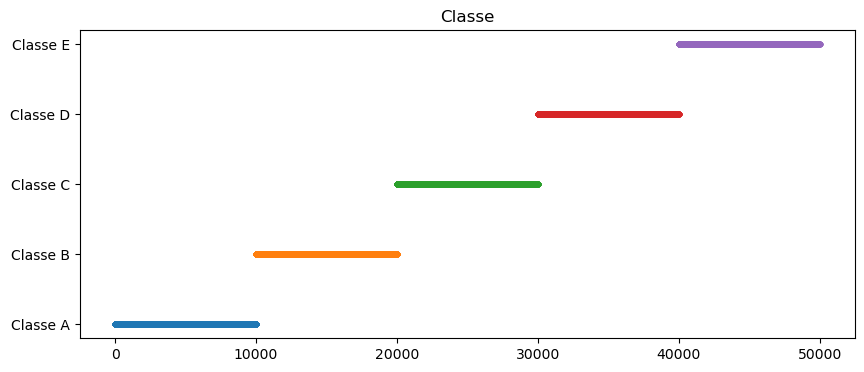

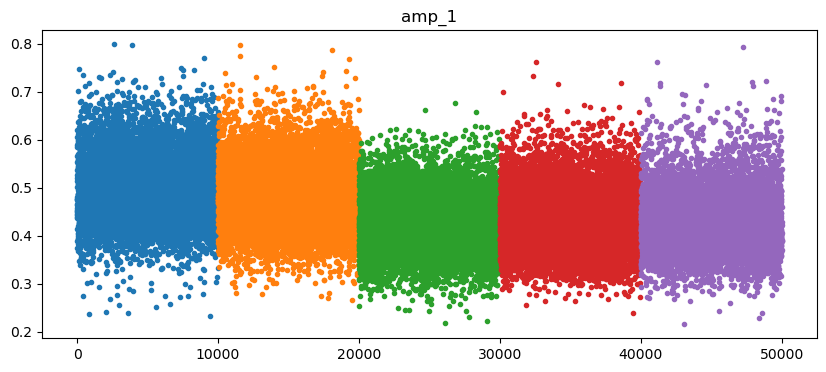

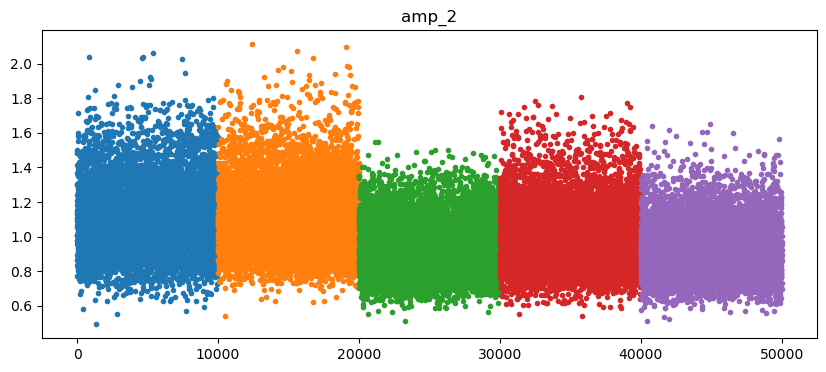

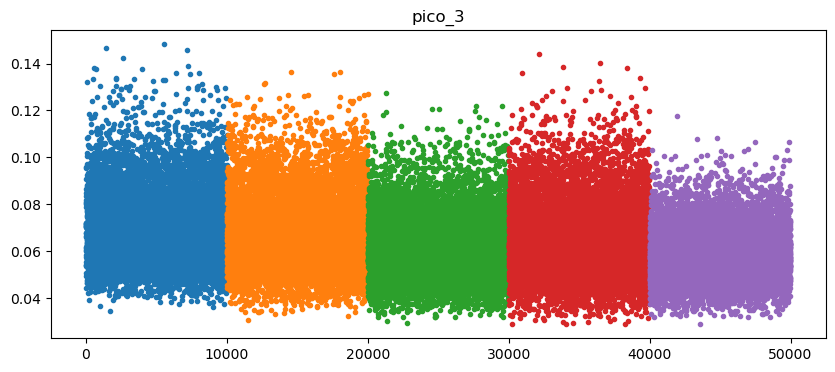

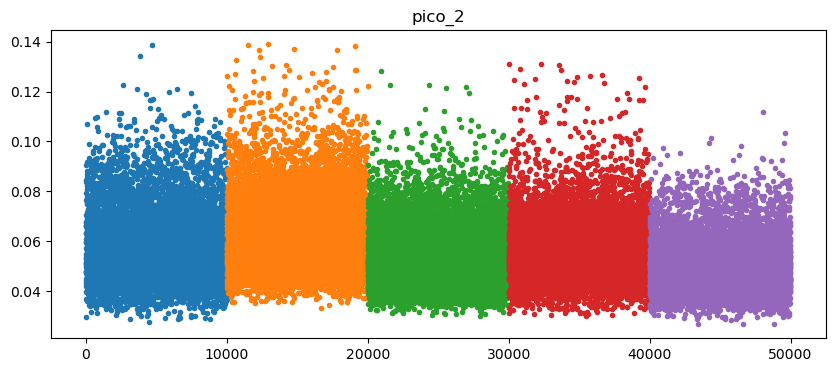

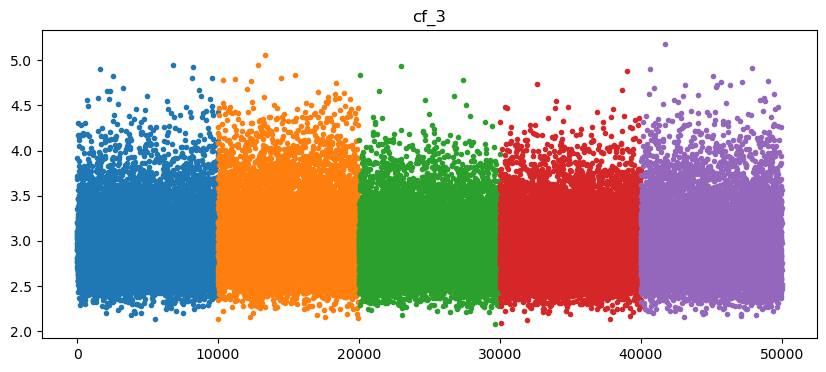

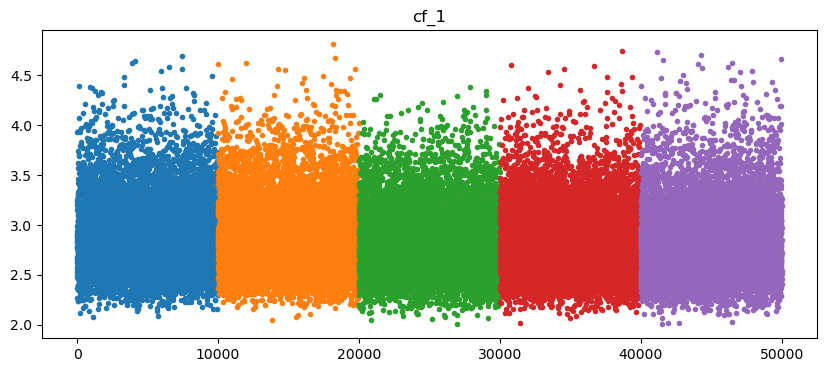

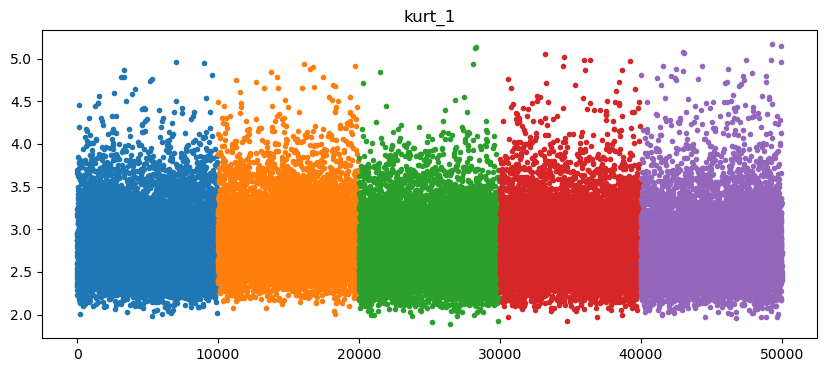

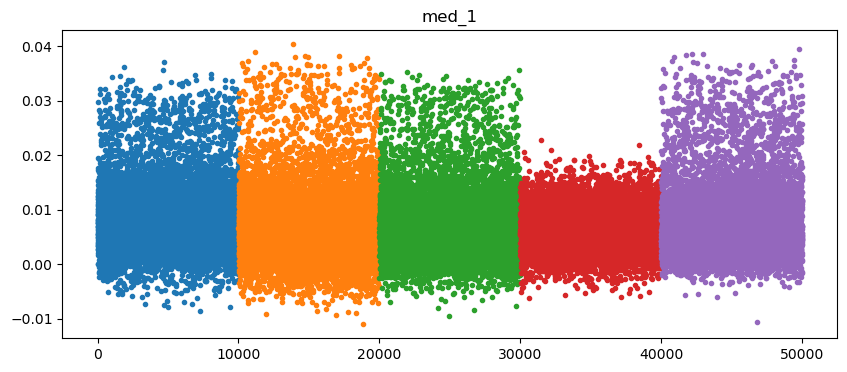

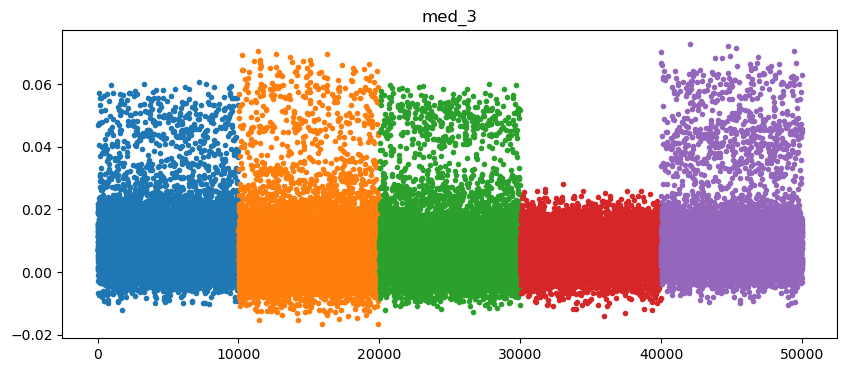

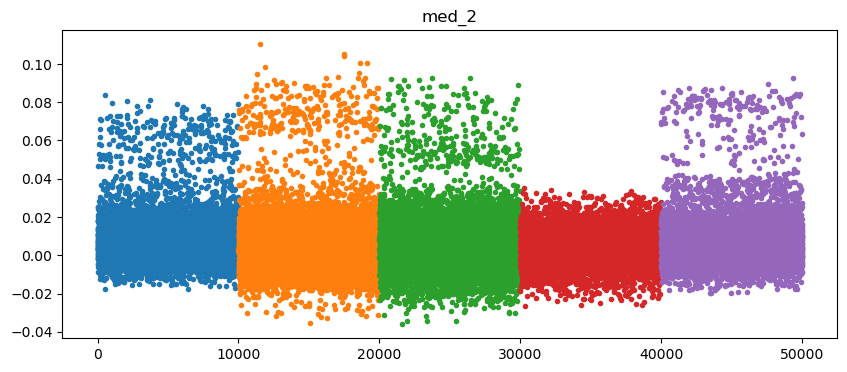

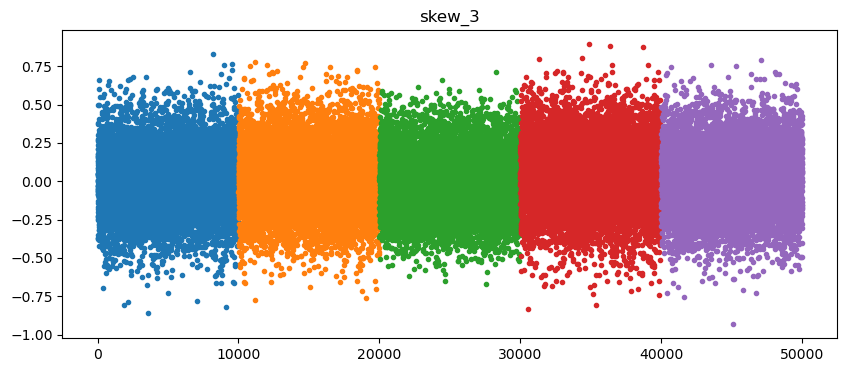

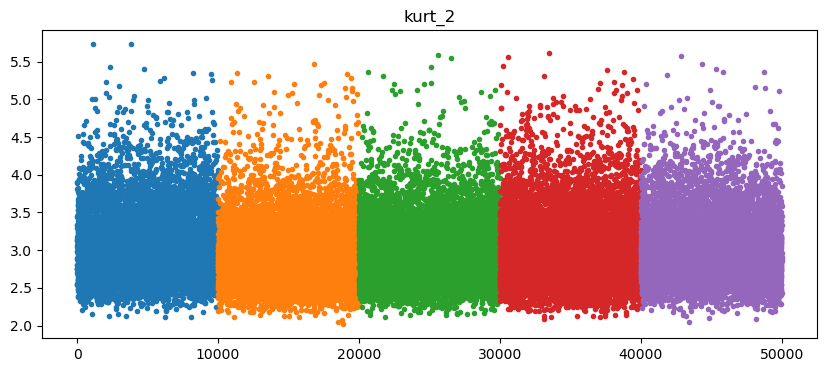

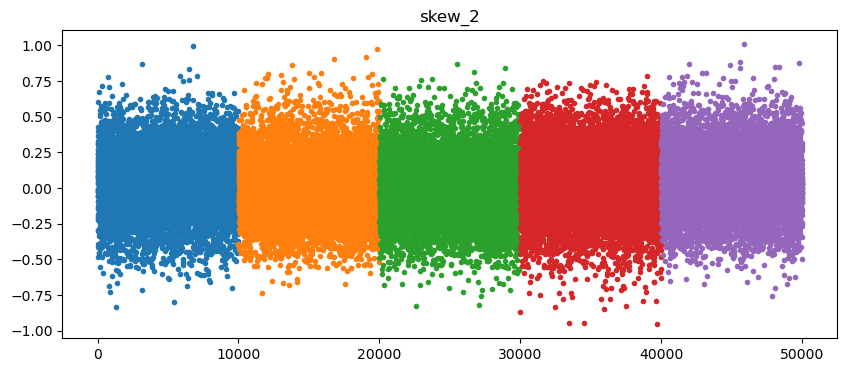

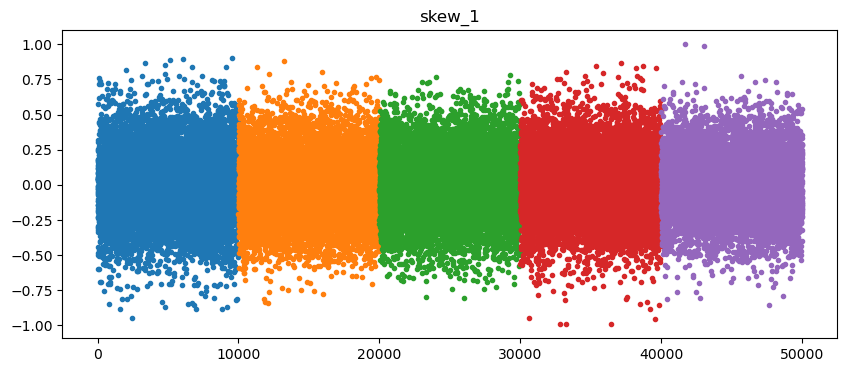

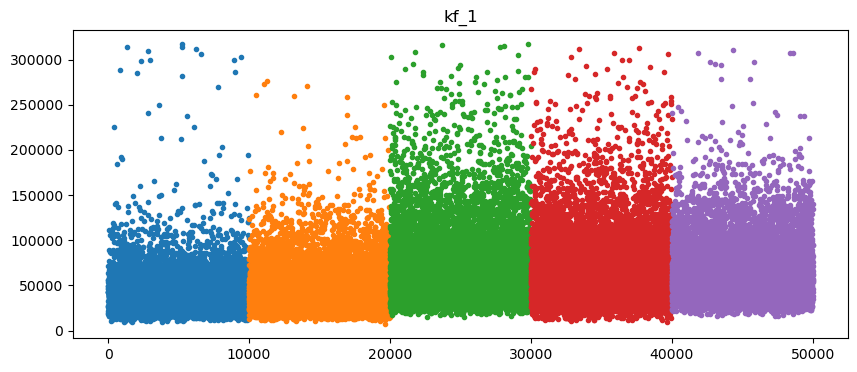

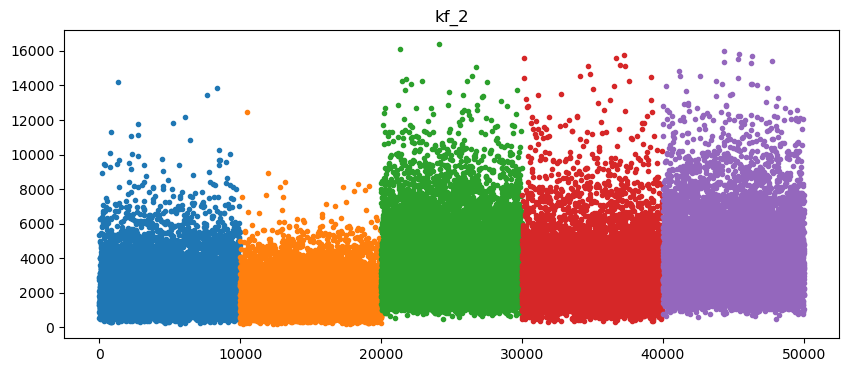

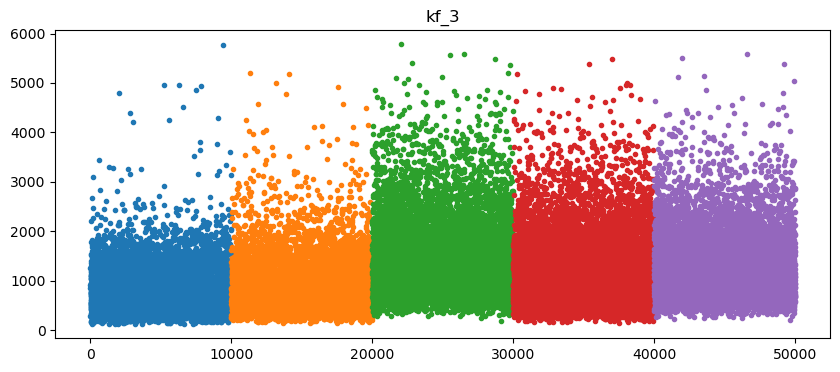

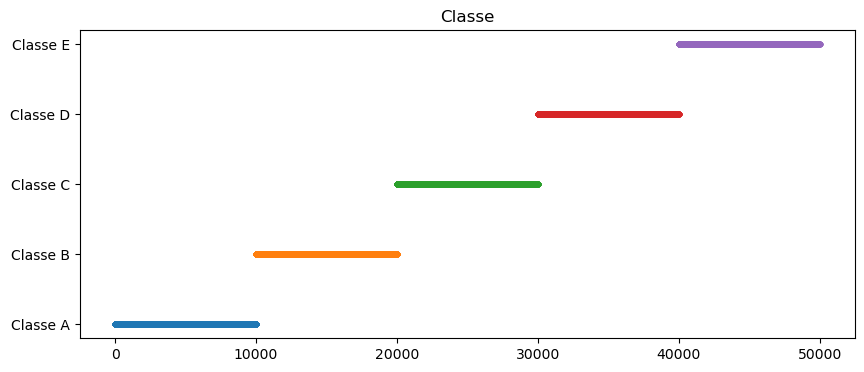

In [12]:
def visualizar(nome):
    plt.figure(figsize=(10, 4))
    plt.title(nome)
    for i in classes:
        plt.plot(df[nome][df['Classe'] == i], '.', label = i)
    plt.show()

visualizar('Classe')
for j in df:
    visualizar(j)
